# Лабораторная работа по курсу NLP. Natural Language Generation
## Репин Владимир 382006-3м

In [1]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TextDataset,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer,
    pipeline)

Используем одну из доступных русскоязычных моделей, способных генерировать текст:

In [31]:
anecmodel = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
witchermodel = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

loading configuration file https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2/resolve/main/config.json from cache at C:\Users\mezotaken/.cache\huggingface\transformers\06f48b6b3173390d047e15d691fda67ae4ea7733a5eea4b6e0115f5099c4e700.b5cdfa39c63384f94159c36bc9042660c747cea5cf520b43d543bd2c68b3164d
Model config GPT2Config {
  "_name_or_path": "sberbank-ai/rugpt3small_based_on_gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 2048,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 2048,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summ

Для правильной работы необходимо использовать токенайзер связанный с моделью:

In [2]:
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Использованный датасет


Для fine-tune модели используется два разных датасета: полная серия книг "Ведьмак" и большой сборник анекдотов.

Для загрузки датасета рекомендуется использовать библиотеку "datasets", но она упорно не устанавливается, поэтому пока данная версия работает - пользуюсь ей. Здесь функция, пользуясь заданным токенайзером делит текст на блоки равного размера и снабжает нужными для data collator методами, чтобы всё это подать для обучения модели.

In [32]:
anec_train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path='anectrain.txt',
    block_size=128)
     
anec_valid_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path='anecvalid.txt',
    block_size=128)

D:\Soft\Anaconda\lib\site-packages\transformers\data\datasets\language_modeling.py:54: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Creating features from dataset file at 
Saving features into cached file cached_lm_GPT2TokenizerFast_128_anectrain.txt [took 0.003 s]
Creating features from dataset file at 
Saving features into cached file cached_lm_GPT2TokenizerFast_128_anecvalid.txt [took 0.001 s]


In [5]:
witcher_train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path='witchertrain.txt',
    block_size=128)
     
witcher_valid_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path='witchervalid.txt',
    block_size=128)

## Fine-tune модели (анекдоты)

Модель Сбербанка основана на gpt2, которая использует Causual Language Modelling, генерацию следующего токена по последовательности. Поэтому в data collator для обучения выключаем Masked Language Modelling, где генерируется последовательность токенов вместо уникального токена маски, включённого в промт.

In [33]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

Устанавливаем необходимые для обучения параметры и создаём объект библиотеки huggingface, который и используется, чтобы обучить модель.

In [34]:
training_args = TrainingArguments(
    overwrite_output_dir = True,
    output_dir = 'anecmodel',
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    learning_rate = 1e-5,
    num_train_epochs = 2,
)

trainer = Trainer(
    model = anecmodel,
    args = training_args,
    data_collator = data_collator,
    train_dataset = anec_train_dataset,
    eval_dataset = anec_valid_dataset
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [35]:
trainer.train()

***** Running training *****
  Num examples = 1038
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 2076


Step,Training Loss
500,3.248100
1000,3.175400
1500,2.946900
2000,2.949000


Saving model checkpoint to anecmodel\checkpoint-500
Configuration saved in anecmodel\checkpoint-500\config.json
Model weights saved in anecmodel\checkpoint-500\pytorch_model.bin
Saving model checkpoint to anecmodel\checkpoint-1000
Configuration saved in anecmodel\checkpoint-1000\config.json
Model weights saved in anecmodel\checkpoint-1000\pytorch_model.bin
Saving model checkpoint to anecmodel\checkpoint-1500
Configuration saved in anecmodel\checkpoint-1500\config.json
Model weights saved in anecmodel\checkpoint-1500\pytorch_model.bin
Saving model checkpoint to anecmodel\checkpoint-2000
Configuration saved in anecmodel\checkpoint-2000\config.json
Model weights saved in anecmodel\checkpoint-2000\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2076, training_loss=3.075748597955428, metrics={'train_runtime': 395.9946, 'train_samples_per_second': 5.242, 'train_steps_per_second': 5.242, 'total_flos': 135610564608000.0, 'train_loss': 3.075748597955428, 'epoch': 2.0})

Сохраним модель и создадим объект для генерации текста из абстракции pipeline.

In [36]:
trainer.save_model()

Saving model checkpoint to anecmodel
Configuration saved in anecmodel\config.json
Model weights saved in anecmodel\pytorch_model.bin


In [37]:
anecgenerator = pipeline('text-generation', tokenizer=tokenizer, model='anecmodel')

loading configuration file anecmodel\config.json
Model config GPT2Config {
  "_name_or_path": "anecmodel",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 2048,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 2048,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.14.1",
  "use_cache": true,
  "vocab_size": 50264
}

loading configuration file anecmodel\config.json
Model config GPT2Config {
  "_name_or_path

In [53]:
print(anecgenerator('Подходит бандит к мужику и', max_length=100,repetition_penalty=1.35)[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Подходит бандит к мужику  и говорит:
- Ты что, с ума сошел? Я тебе дам пистолет!!. А ты мне - бутылку водки. Ну давай...

Мужик достает из кармана пачку денег (в рублях), протягивает бандиту и спрашивает у него паспорт : "А вы кто такой будете?" Тот отвечает ему в ответ: "Я русский". И тут мужик начинает стрелять по нему со всех стволов...

Бандит падает замертво от страха.


## Fine-tune модели (Ведьмак)

In [9]:
training_args = TrainingArguments(
    overwrite_output_dir = True,
    output_dir = 'witchermodel',
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    learning_rate = 3e-5,
    num_train_epochs = 1,
    save_total_limit = 1
)

trainer = Trainer(
    model = witchermodel,
    args = training_args,
    data_collator = data_collator,
    train_dataset = witcher_train_dataset,
    eval_dataset = witcher_valid_dataset
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [10]:
trainer.train()

***** Running training *****
  Num examples = 10468
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 10468


Step,Training Loss
500,3.634200
1000,3.609300
1500,3.534100
2000,3.538900
2500,3.513000
3000,3.458400
3500,3.456700
4000,3.457700
4500,3.447100
5000,3.376900


Saving model checkpoint to witchermodel\checkpoint-500
Configuration saved in witchermodel\checkpoint-500\config.json
Model weights saved in witchermodel\checkpoint-500\pytorch_model.bin
Deleting older checkpoint [witchermodel\checkpoint-8000] due to args.save_total_limit
Saving model checkpoint to witchermodel\checkpoint-1000
Configuration saved in witchermodel\checkpoint-1000\config.json
Model weights saved in witchermodel\checkpoint-1000\pytorch_model.bin
Deleting older checkpoint [witchermodel\checkpoint-500] due to args.save_total_limit
Saving model checkpoint to witchermodel\checkpoint-1500
Configuration saved in witchermodel\checkpoint-1500\config.json
Model weights saved in witchermodel\checkpoint-1500\pytorch_model.bin
Deleting older checkpoint [witchermodel\checkpoint-1000] due to args.save_total_limit
Saving model checkpoint to witchermodel\checkpoint-2000
Configuration saved in witchermodel\checkpoint-2000\config.json
Model weights saved in witchermodel\checkpoint-2000\pyto

TrainOutput(global_step=10468, training_loss=3.4215032965981145, metrics={'train_runtime': 2001.8402, 'train_samples_per_second': 5.229, 'train_steps_per_second': 5.229, 'total_flos': 683801247744000.0, 'train_loss': 3.4215032965981145, 'epoch': 1.0})

In [11]:
trainer.save_model()

Saving model checkpoint to witchermodel
Configuration saved in witchermodel\config.json
Model weights saved in witchermodel\pytorch_model.bin


In [6]:
witchergenerator = pipeline('text-generation', tokenizer=tokenizer, model='witchermodel')

In [64]:
print(witchergenerator('- Что такое огонь? ', max_length=200,repetition_penalty=1.2)[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


- Что такое огонь?  Это пламя, которое горит в огне.

– Огонь – это вода, – сказал Геральт. – Вода – это огонь. А огонь… Он не может быть холодным и холодным. Не может быть холодным и холодным.

– Холодным и холодным огнем, – повторил Лютик. – Огнем, который сжигает все живое на свете. И даже людей. Но ты же знаешь, что я имею в виду. Я знаю, как выглядит огонь. Ты можешь его увидеть. Увидеть, как он пылает. Как горят деревья, цветы, листья, трава, небо, звезды. Все, что есть огня.

– Нет! – крикнул ведьмак. – Нет! Этого нет!

– Да будет так, – сказала Цири. – Так пусть этот огонь погаснет. Пусть он погасит то, чего мы боимся больше всего.

Она подняла руку, коснулась пламени, но оно было слишком мягким для нее. Она


In [65]:
print(witchergenerator('- Что такое огонь? ', max_length=200,repetition_penalty=1.45)[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


- Что такое огонь?  Это пламя, которое горит в огне.

– Огонь – это вода! Вода… Она не может быть водой и огнем. Не должна сгореть вместе с тобой на этом свете. Ты должен ее спасти от огня. Я знаю тебя лучше всех. И я помогу тебе сделать то же самое со мной. Только ты можешь меня уберечь».

Он молчал долго. Потом сказал: «Я хочу знать все о том пламени…» Он знал об огненном потоке воды из озера Брокилон. О воде, которая течет по его лицу сквозь пальцы. Об озере, который он видел во сне. Озеро было черным как смоль, а небо затянуто тучами молний. Но Цири знала также, что озеро действительно черное. А она видела воду под ногами у него за спиной. В темноте. На дне пруда. Под ним была черная лужа крови. Кровь текла прямо ему навстречу. У нее были руки, ноги, волосы цвета воронова крыла. Ее глаза


Тут смешные промты получить сложно, но это и не было целью. Интересно было посмотреть, как близко к стилю книг получится сгенерированный текст, а оказалось очень близко, не хватает только смысла. 

Также стоит отметить, что штрафом за повторения можно регулировать диалоги и описательный текст, мне кажется потому, что штрафуются дефисы, которые в диалогах часто повторяются.

## Забавные результаты от модели на анекдотах

---


Мужик приходит домой пьяный после работы к жене со словами :

\- Жена, а давай купим машину за полцены? Я уже купил ее вчера вечером, но она стоит того чтобы купить её сегодня утром...

---

Заходит улитка в бар и спрашивает у барменши:

\- Скажите, а вы не знаете почему я такая толстая? Я же ем только бананы!

Барменша отвечает ей с улыбкой. Она говорит : "Потому что ты ешь их каждый день".


---

Врач: "У вас есть минутки?"

Мужик: "Да". Врач: "А сколько вам лет?". Мужик: "Двадцать один год... . Врач: "И что же вы делаете с этими часами?!"


---

Заходят в бар русский, американец и еврей.
\- Ну что? - спрашивает бармен у русского:
\- Я заказал пиво "Бургер Кинг"..

Русский отвечает:

"Давай по сто грамм", а потом добавляет еще два слова на иврите: "Пьяный я! ". И тут же поворачивается к еврею спиной...


---

Врач:
\- У вас есть сахарный диабет или ожирение?

Мужик (с улыбкой):

\- Нету сахара!!!

доктор:

\- Ну и дурак же ты, мужик!!!! Ты хоть бы ложку принес!


---

Как доехать до Нижнего Новгорода?
\- А что, есть варианты?!?.

---

## Дополнительно

### Промт от оригинальной модели Сбербанка

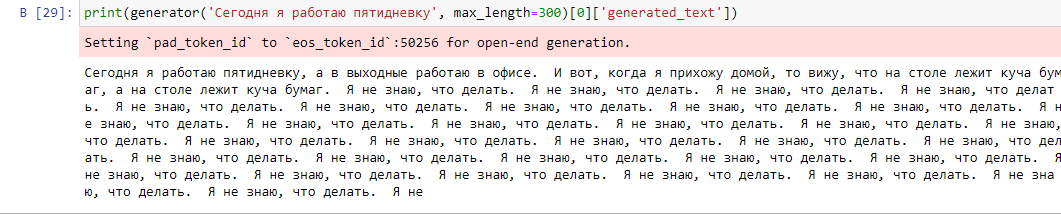

### Наверное, это даже лучше, чем анекдоты

Тексты выше сгенерированы уже в финальной версии, но была ещё самая первая, где датасетом служила смесь ведмака и анекдотов(из другого сборника) в пропорции 1:4. Потом уже стало ясно, что это бессмысленно, учитывая как работает модель. Тренировка там была очень быстрой, пробной, на малом сабсете и результаты были очень странными. Сохранилось это в виде скринов, которые пересылались паре друзей, не участвовавших в курсе.

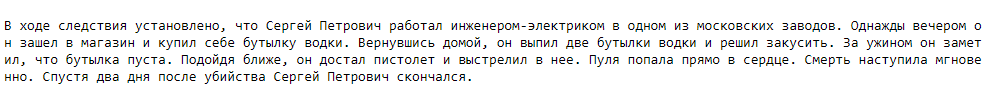

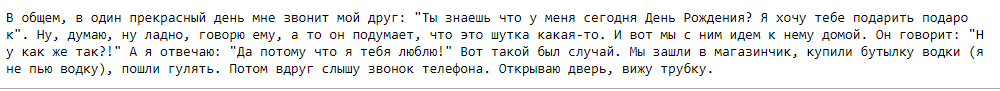

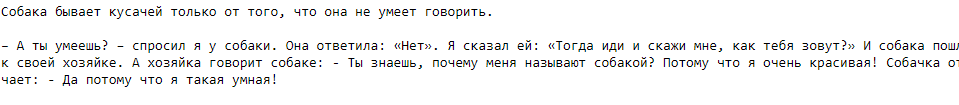

### Крайне странные результаты из той же первой пробы

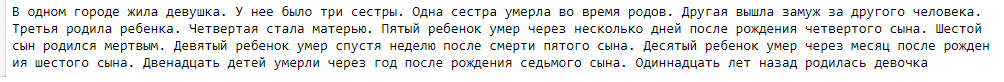

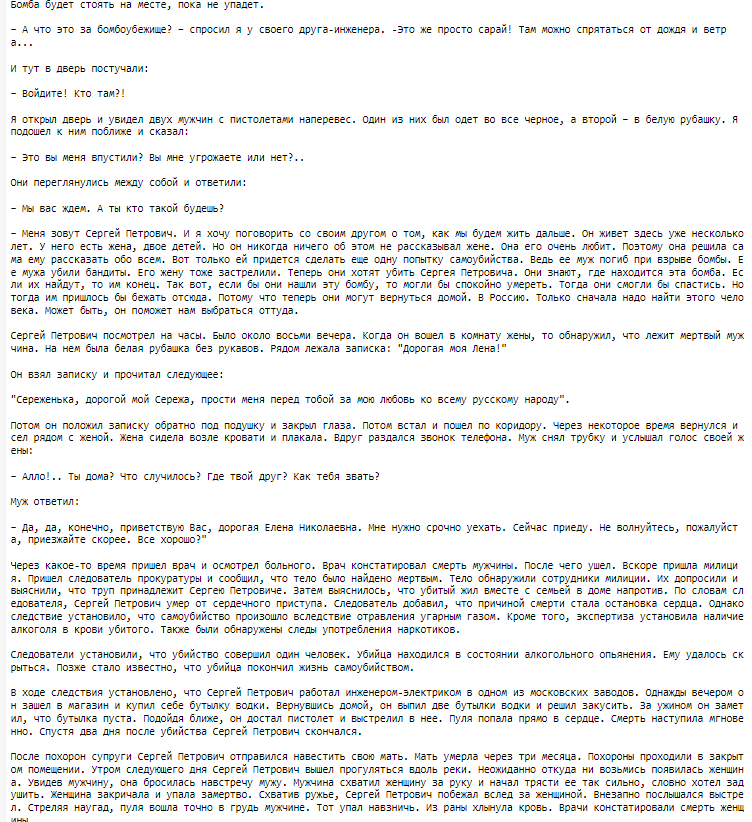